# HRNet

IMPORTANT: before running the code below, open the termnal in Jupiter and run the following code line:

**apt install libgl1-mesa-glx** 

In [1]:
!pip install semtorch
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

from pathlib import Path
import random

%matplotlib inline
import numpy as np

     |████████████████████████████████| 41 kB 1.4 MB/s  eta 0:00:01


  Created wheel for semtorch: filename=SemTorch-0.1.1-py3-none-any.whl size=50567 sha256=da3dcecc1e32a27927d120d828ecd5f243b489e1f34ed7e85f8689e2db943d81
  Stored in directory: /root/.cache/pip/wheels/36/64/26/8bf2eaf02cd641d99d34161b14fb87bcc3b66bc2d5e47566d5
Successfully built semtorch


/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
%matplotlib inline
import numpy as np

In [3]:
number_of_the_seed = 100

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
#My file path is being desing to look like this one. 
path = Path("../dataset2/")
#image is a normal microscope image. It's in png format. 
path_images = path/"Images"
#labels are the masks balck and white. In tif format. 
path_labels = path/"Labels"

test_name = "test"

In [5]:
get_y_fn = lambda x: path_labels/manual_name/f'Mask_{str(x.stem[-3:])}.tif'

In [6]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

In [7]:
def hrnet_splitter(model):
    return [params(model.backbone), params(model.head)]

In [8]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['NoSpheroid']


{'NoSpheroid': 0, 'Spheroid': 1}


In [9]:
def pixel_accuracy(inp, targ, axis):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    
    #the mask is the targ pixels different from NoSpheroid
    mask = targ != void_code
    #[0]
    #when the predicted pixels and targets pixels named spheroid correlates, we calculate the mean. 
    return (pred[mask] == targ[mask]).float().mean()

In [10]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 1
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [11]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [12]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

https://github.com/martinkersner/py_img_seg_eval/blob/master/eval_segm.py

# Manual 

In [13]:
manual_name="manual"

path_manual_img = path_images/manual_name
path_manual_lbl = path_labels/manual_name

In [14]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

../dataset2/Images/manual/Droplet_101.jpg


<AxesSubplot:>

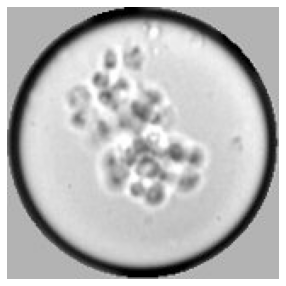

In [15]:
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

../dataset2/Labels/manual/Mask_101.tif


<AxesSubplot:>

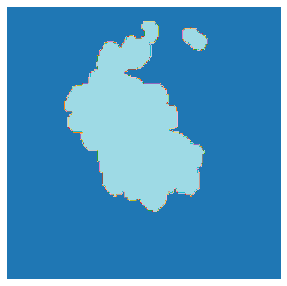

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
print(torch.max(image2tensor(mask)))

tensor(255, dtype=torch.uint8)


In [19]:
size = 1002
bs = 32

In [20]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater


Setting-up type transforms pipelines
Found 630 items
2 datasets of sizes 567,63
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../dataset2/Images/manual/Droplet_264.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=160x160
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../dataset2/Images/manual/Droplet_264.jpg
    applying <lambda> gives
      ../dataset2/Labels/manual/Mask_264.tif
    applying PILBase.create gives
      PILMask mode=L size=171x171

Final sample: (PILImage mode=RGB size=160x160, PILMask mode=L size=171x171)


Found 630 items
2 datasets of sizes 567,63
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create
Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (160, 160), 'method': 'crop', 'pad_mode': 'reflection', 'resam

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


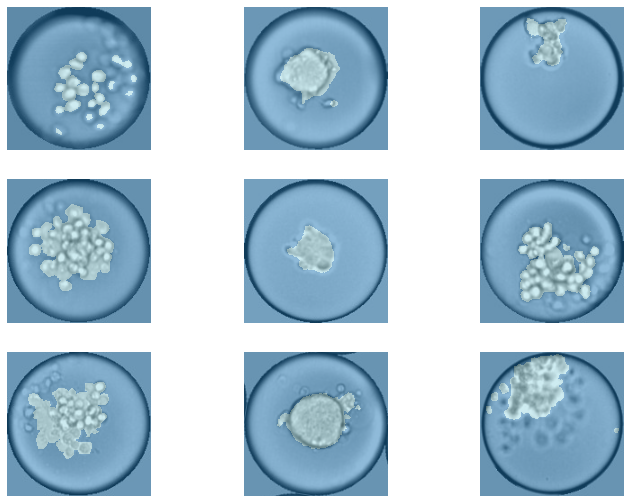

In [21]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((160,160)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

# First round of training 

Let's start with the wd = 1e-2

Two different loss functions were tested: 
- default one: CrossEntropyLoss
- DiceLoss(axis=1, smooth=1, reduction='mean', square_in_union=True)

In [22]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w18", 
                                 metrics=[partial(pixel_accuracy, axis=1), Dice(), JaccardCoeff()], wd=1e-2,
                                 splitter=hrnet_splitter, pretrained=True, loss_func= DiceLoss(axis=1, smooth=1, reduction='mean', square_in_union=False)).to_fp16()
learn.freeze()
#for accuracy partial(accuracy, axis=1)


100%|██████████| 83749/83749 [00:03<00:00, 23276.76KB/s]


IMPORTANT: when using DiceLoss set the folowing parameters. Tbh I dont really know what they do we we achieved lower loss, between (0.6-0.20)
DiceLoss(axis=1, smooth=1, reduction='mean', square_in_union=False))

New trial square_in_union=True, the loss lies around (0.5-0.15)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Recorder

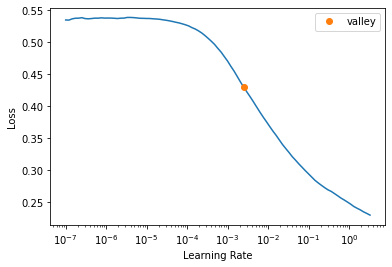

In [25]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.123281,0.453002,0.997826,0.421104,0.266708,00:14
1,0.107899,0.333458,0.996041,0.533447,0.363742,00:14
2,0.098610,0.190819,0.989847,0.702877,0.541874,00:16
3,0.092432,0.171693,0.988301,0.724845,0.568436,00:14
4,0.087652,0.090170,0.944885,0.850025,0.739168,00:13
5,0.084022,0.078451,0.935893,0.867695,0.766308,00:13
6,0.081822,0.087920,0.951489,0.853683,0.744718,00:16
7,0.081197,0.078526,0.918137,0.867187,0.765517,00:15
8,0.079099,0.071317,0.873038,0.879440,0.784822,00:16
9,0.077689,0.086866,0.945566,0.854118,0.745380,00:17


Better model found at epoch 0 with valid_loss value: 0.4530024528503418.


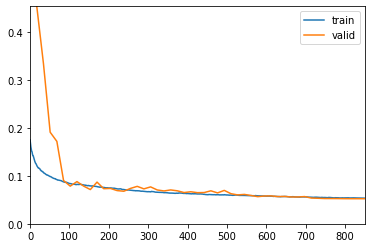

Better model found at epoch 1 with valid_loss value: 0.3334575891494751.
Better model found at epoch 2 with valid_loss value: 0.1908189058303833.
Better model found at epoch 3 with valid_loss value: 0.17169268429279327.
Better model found at epoch 4 with valid_loss value: 0.09017028659582138.
Better model found at epoch 5 with valid_loss value: 0.07845143228769302.
Better model found at epoch 8 with valid_loss value: 0.07131686061620712.
Better model found at epoch 12 with valid_loss value: 0.06918976455926895.
Better model found at epoch 13 with valid_loss value: 0.06783273816108704.
Better model found at epoch 22 with valid_loss value: 0.06510133296251297.
Better model found at epoch 24 with valid_loss value: 0.06485632061958313.
Better model found at epoch 27 with valid_loss value: 0.06436540186405182.
Better model found at epoch 29 with valid_loss value: 0.06271736323833466.
Better model found at epoch 30 with valid_loss value: 0.06019394099712372.
Better model found at epoch 32 wi

In [27]:
fname="HRNet_Aug_wd2_model_1_hrnet_w18_bs_32_Dice_loss"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=5),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, slice(1e-3,1e-1),cbs=callbacksFitBeforeUnfreeze)

In [28]:
learn.load("HRNet_Aug_wd2_model_1_hrnet_w18_bs_32_Dice_loss")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.05223934352397919,0.920607328414917,0.9081993680816559,0.831836272604008]

In [29]:
learn.freeze()

In [30]:
lr =5e-2
lrs = slice(lr/400, lr/4)
lr, lrs

(0.05, slice(0.000125, 0.0125, None))

In [31]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.066484,0.064398,0.918043,0.887004,0.796951,00:20
1,0.065037,0.077614,0.949070,0.865977,0.763632,00:20
2,0.064263,0.074136,0.955151,0.872635,0.774048,00:20
3,0.062380,0.068539,0.942556,0.883594,0.791463,00:20
4,0.061079,0.060847,0.884044,0.897116,0.813427,00:20
5,0.060269,0.057123,0.895572,0.902059,0.821591,00:20
6,0.059171,0.055013,0.912132,0.904412,0.825503,00:19
7,0.058008,0.056122,0.926423,0.903698,0.824315,00:20
8,0.057046,0.070655,0.962332,0.881745,0.788501,00:20
9,0.056180,0.057684,0.950285,0.900651,0.819258,00:20


Better model found at epoch 0 with valid_loss value: 0.06439819186925888.


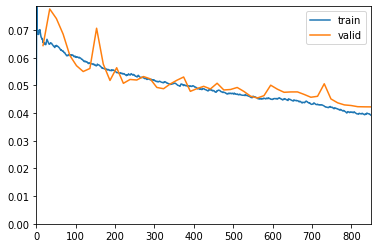

Better model found at epoch 4 with valid_loss value: 0.06084680184721947.
Better model found at epoch 5 with valid_loss value: 0.057122740894556046.
Better model found at epoch 6 with valid_loss value: 0.05501341074705124.
Better model found at epoch 10 with valid_loss value: 0.051794108003377914.
Better model found at epoch 12 with valid_loss value: 0.0507526732981205.
Better model found at epoch 17 with valid_loss value: 0.04926157742738724.
Better model found at epoch 18 with valid_loss value: 0.04880216345191002.
Better model found at epoch 22 with valid_loss value: 0.047855377197265625.
Better model found at epoch 30 with valid_loss value: 0.047824129462242126.
Better model found at epoch 31 with valid_loss value: 0.046100717037916183.
Better model found at epoch 32 with valid_loss value: 0.04544444382190704.
Better model found at epoch 43 with valid_loss value: 0.045106831938028336.
Better model found at epoch 44 with valid_loss value: 0.0437115877866745.
Better model found at ep

In [32]:
fname="HRNet_Aug_wd2_model_2_hrnet_w18_bs_32_Dice_loss"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=5),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)]
learn.fit_flat_cos(50, lrs, cbs=callbacksFitBeforeUnfreeze)

In [33]:
learn.freeze()

In [23]:
learn.load("HRNet_Aug_wd2_model_2_hrnet_w18_bs_32_Dice_loss")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#4) [0.04224076122045517,0.929268479347229,0.923136690925236,0.8572459319079139]

In [24]:
learn.unfreeze()

Recorder

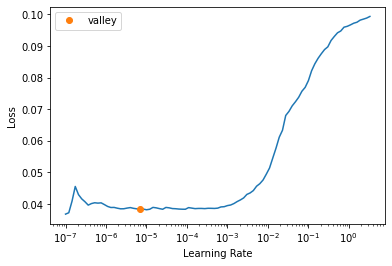

In [36]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [25]:
lrs=slice(1e-7, 1e-6)

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.037686,0.042229,0.929598,0.923151,0.857271,00:15
1,0.038256,0.042249,0.930130,0.923172,0.857307,00:15
2,0.038339,0.042257,0.930430,0.923122,0.857220,00:14
3,0.038649,0.042253,0.930862,0.923177,0.857315,00:14
4,0.038677,0.042257,0.930980,0.923146,0.857262,00:14
5,0.038660,0.042256,0.931152,0.923173,0.857308,00:14
6,0.038589,0.042254,0.931385,0.923155,0.857278,00:15
7,0.038496,0.042265,0.931554,0.923128,0.857231,00:15
8,0.038500,0.042255,0.931581,0.923104,0.857189,00:15
9,0.038276,0.042262,0.931703,0.923080,0.857147,00:15


Better model found at epoch 0 with valid_loss value: 0.04222928360104561.


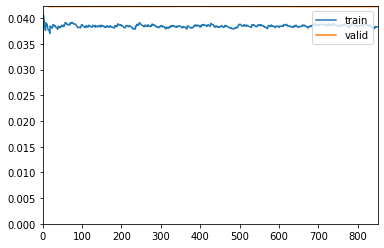

Better model found at epoch 38 with valid_loss value: 0.04222623258829117.


In [26]:
fname="HRNet_Aug_wd2_model_3_hrnet_w18_bs_32_Dice_loss"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=5),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)]
learn.fit_flat_cos(50, lrs, cbs=callbacksFitBeforeUnfreeze)

In [27]:
learn.load("HRNet_Aug_wd2_model_3_hrnet_w18_bs_32_Dice_loss")
learn.validate()

(#4) [0.04222623258829117,0.9319338202476501,0.9232309232309233,0.857408466819222]

Recorder

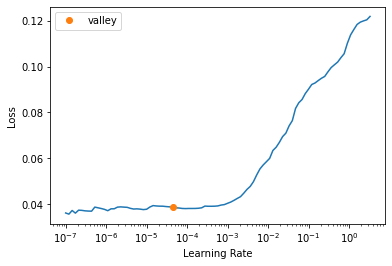

In [28]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.037360,0.042205,0.930478,0.923231,0.857408,00:15
1,0.037996,0.042295,0.931754,0.923119,0.857216,00:15
2,0.038048,0.042558,0.929372,0.922396,0.855969,00:14
3,0.038293,0.042536,0.930642,0.922407,0.855988,00:14
4,0.038141,0.042330,0.931634,0.922973,0.856963,00:15
5,0.037765,0.042344,0.926632,0.922684,0.856466,00:14
6,0.038074,0.042473,0.927508,0.922597,0.856315,00:15
7,0.038023,0.042196,0.930001,0.923055,0.857106,00:15
8,0.037883,0.042159,0.928749,0.923121,0.857219,00:15
9,0.037700,0.042067,0.928592,0.923420,0.857735,00:15


Better model found at epoch 0 with valid_loss value: 0.04220506176352501.


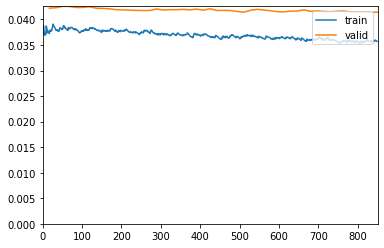

Better model found at epoch 7 with valid_loss value: 0.0421958789229393.
Better model found at epoch 8 with valid_loss value: 0.042159099131822586.
Better model found at epoch 9 with valid_loss value: 0.042066700756549835.
Better model found at epoch 10 with valid_loss value: 0.04190833494067192.
Better model found at epoch 11 with valid_loss value: 0.04186227545142174.
Better model found at epoch 12 with valid_loss value: 0.041816893965005875.
Better model found at epoch 13 with valid_loss value: 0.04177236557006836.
Better model found at epoch 14 with valid_loss value: 0.041747841984033585.
Better model found at epoch 25 with valid_loss value: 0.04174737259745598.
Better model found at epoch 28 with valid_loss value: 0.041576825082302094.
Better model found at epoch 29 with valid_loss value: 0.04140963777899742.


In [29]:
fname="HRNet_Aug_wd2_model_4_hrnet_w18_bs_32_Dice_loss"
callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=5),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)]
learn.fit_flat_cos(50, slice(9e-6,3e-6), cbs=callbacksFitBeforeUnfreeze)

# Second round of training 

Here we try with wd = 1e-1

loss_func= DiceLoss(axis=1, smooth=1, reduction='mean', square_in_union=False
                            

In [22]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w32", 
                                 metrics=[partial(pixel_accuracy, axis=1), Dice(), JaccardCoeff()],
                                 loss_func= DiceLoss(axis=1, smooth=1, reduction='mean', square_in_union=False), wd=1e-1, 
                                 pretrained=True, splitter=hrnet_splitter).to_fp16()
learn.freeze()

100%|██████████| 161707/161707 [00:06<00:00, 23216.04KB/s]


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Recorder

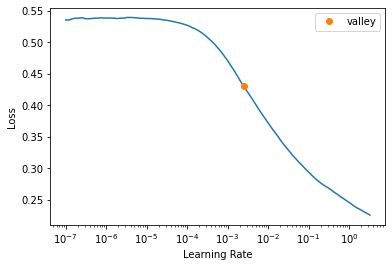

In [23]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.126119,0.353662,0.989823,0.677188,0.511931,00:12
1,0.123222,0.291117,0.985833,0.717378,0.559306,00:12
2,0.117733,0.224789,0.980336,0.755197,0.606680,00:12
3,0.111981,0.162006,0.969493,0.800431,0.667266,00:12
4,0.105872,0.123737,0.960813,0.824605,0.701556,00:12
5,0.100081,0.103246,0.951955,0.842458,0.727800,00:12
6,0.094800,0.098108,0.952855,0.843767,0.729756,00:12
7,0.090718,0.090841,0.944772,0.853880,0.745017,00:12
8,0.086674,0.094077,0.958437,0.846495,0.733846,00:12
9,0.083826,0.106062,0.968603,0.825919,0.703460,00:12


Better model found at epoch 0 with valid_loss value: 0.35366180539131165.


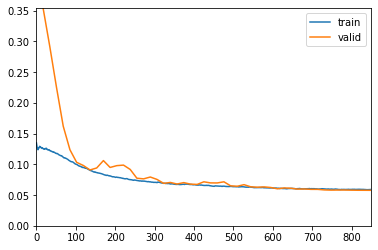

Better model found at epoch 1 with valid_loss value: 0.2911171615123749.
Better model found at epoch 2 with valid_loss value: 0.22478921711444855.
Better model found at epoch 3 with valid_loss value: 0.16200615465641022.
Better model found at epoch 4 with valid_loss value: 0.123736672103405.
Better model found at epoch 5 with valid_loss value: 0.10324572026729584.
Better model found at epoch 6 with valid_loss value: 0.09810776263475418.
Better model found at epoch 7 with valid_loss value: 0.09084086865186691.
Better model found at epoch 14 with valid_loss value: 0.07736946642398834.
Better model found at epoch 15 with valid_loss value: 0.07635226845741272.
Better model found at epoch 17 with valid_loss value: 0.075446218252182.
Better model found at epoch 18 with valid_loss value: 0.06904662400484085.
Better model found at epoch 20 with valid_loss value: 0.06795942038297653.
Better model found at epoch 22 with valid_loss value: 0.06777182221412659.
Better model found at epoch 23 with v

In [25]:
fname="HRNet_Aug_wd1_model_1_hrnet_w18_bs_32_Dice_loss"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=5),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, slice(1e-3,1e-1),cbs=callbacksFitBeforeUnfreeze)

Now we follow the rule of thumb.

In [26]:
learn.load("HRNet_Aug_wd1_model_1_hrnet_w18_bs_32_Dice_loss")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.057709384709596634,0.9206566214561462,0.9001443535903207,0.8184204504733986]

In [27]:
lr = 4e-2
lrs = slice(lr/400, lr/4)
lr, lrs

(0.04, slice(0.0001, 0.01, None))

In [28]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.059205,0.057668,0.919863,0.900193,0.818501,00:15
1,0.058823,0.057675,0.919761,0.900197,0.818507,00:14
2,0.059084,0.057663,0.918877,0.900206,0.818523,00:14
3,0.058905,0.057594,0.917563,0.900225,0.818554,00:14
4,0.058732,0.057636,0.918166,0.900207,0.818525,00:14
5,0.059065,0.057800,0.918325,0.899854,0.817940,00:14
6,0.058983,0.057783,0.919830,0.899815,0.817876,00:14
7,0.059034,0.057383,0.912503,0.900429,0.818892,00:14
8,0.058934,0.057542,0.919444,0.900269,0.818627,00:14
9,0.058827,0.057308,0.918335,0.900986,0.819812,00:14


Better model found at epoch 0 with valid_loss value: 0.057668112218379974.


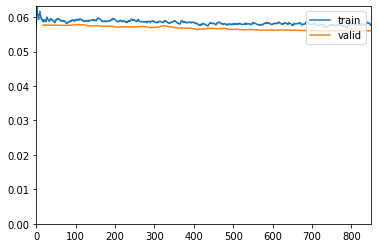

Better model found at epoch 2 with valid_loss value: 0.05766332894563675.
Better model found at epoch 3 with valid_loss value: 0.05759395286440849.
Better model found at epoch 7 with valid_loss value: 0.057382985949516296.
Better model found at epoch 9 with valid_loss value: 0.05730836093425751.
Better model found at epoch 11 with valid_loss value: 0.057096466422080994.
Better model found at epoch 16 with valid_loss value: 0.05696794018149376.
Better model found at epoch 20 with valid_loss value: 0.056896187365055084.
Better model found at epoch 21 with valid_loss value: 0.056741729378700256.
Better model found at epoch 23 with valid_loss value: 0.05642063543200493.
Better model found at epoch 30 with valid_loss value: 0.05632195249199867.
Better model found at epoch 32 with valid_loss value: 0.05628404766321182.
Better model found at epoch 33 with valid_loss value: 0.0562015175819397.
Better model found at epoch 37 with valid_loss value: 0.0561990886926651.
Better model found at epoch

In [29]:
fname="HRNet_Aug_wd1_model_2_hrnet_w18_bs_32_Dice_loss"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=5),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, lrs, cbs=callbacksFitBeforeUnfreeze)

In [30]:
learn.load("HRNet_Aug_wd1_model_2_hrnet_w18_bs_32_Dice_loss")
learn.validate()

(#4) [0.05602168291807175,0.9156609773635864,0.9028910481426321,0.8229730024662258]

Recorder

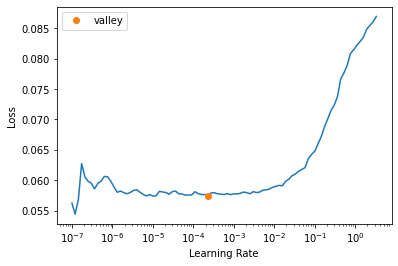

In [31]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [32]:
lr = slice(1e-7, 1e-6)

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.057758,0.056010,0.915749,0.902940,0.823055,00:14
1,0.058227,0.056007,0.915869,0.902935,0.823046,00:14
2,0.058098,0.056006,0.915519,0.902921,0.823022,00:14
3,0.057650,0.056005,0.915321,0.902928,0.823034,00:15
4,0.057674,0.055998,0.915124,0.902883,0.822960,00:14
5,0.057908,0.056002,0.915091,0.902899,0.822987,00:14
6,0.057808,0.056002,0.915004,0.902889,0.822969,00:14
7,0.057654,0.055988,0.914811,0.902918,0.823018,00:14
8,0.057650,0.056006,0.914963,0.902915,0.823013,00:14
9,0.057918,0.056001,0.914881,0.902903,0.822993,00:14


Better model found at epoch 0 with valid_loss value: 0.05601004883646965.


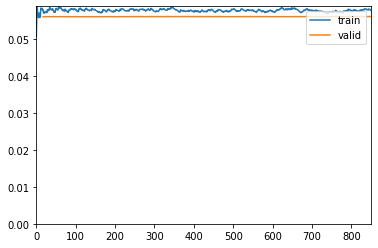

Better model found at epoch 1 with valid_loss value: 0.056007031351327896.
Better model found at epoch 2 with valid_loss value: 0.05600649118423462.
Better model found at epoch 3 with valid_loss value: 0.05600503832101822.
Better model found at epoch 4 with valid_loss value: 0.05599837750196457.
Better model found at epoch 7 with valid_loss value: 0.055988479405641556.


In [33]:
fname="HRNet_Aug_wd1_model_3_hrnet_w18_bs_32_Dice_loss"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=5),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, lr, cbs=callbacksFitBeforeUnfreeze)

In [34]:
learn.load("HRNet_Aug_wd1_model_3_hrnet_w18_bs_32_Dice_loss")
learn.validate()

(#4) [0.055988479405641556,0.9148114919662476,0.9029182524997843,0.8230182067627616]

Recorder

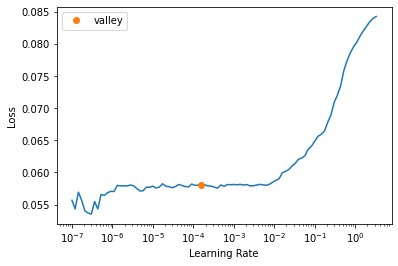

In [35]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.057366,0.055983,0.914730,0.902932,0.823041,00:14
1,0.057856,0.055982,0.914659,0.902915,0.823012,00:14
2,0.057992,0.055972,0.914855,0.902945,0.823062,00:15
3,0.057806,0.055984,0.915024,0.902930,0.823038,00:14
4,0.057987,0.055989,0.914959,0.902939,0.823053,00:14
5,0.057938,0.056005,0.915260,0.902892,0.822975,00:15
6,0.057756,0.056009,0.915276,0.902861,0.822923,00:15
7,0.057576,0.056009,0.914867,0.902887,0.822966,00:14
8,0.057393,0.056014,0.915024,0.902869,0.822937,00:14
9,0.057622,0.056005,0.915087,0.902856,0.822915,00:14


Better model found at epoch 0 with valid_loss value: 0.055983223021030426.


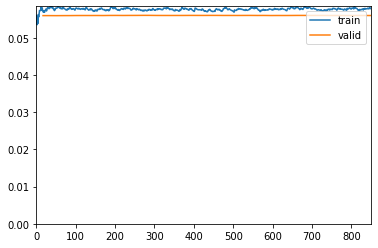

Better model found at epoch 1 with valid_loss value: 0.05598171800374985.
Better model found at epoch 2 with valid_loss value: 0.05597156286239624.


In [36]:
fname="HRNet_Aug_wd1_model_4_hrnet_w18_bs_32_Dice_loss"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=5),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, slice(1e-7,1e-5), cbs=callbacksFitBeforeUnfreeze)

In [37]:
learn.load("HRNet_Aug_wd1_model_4_hrnet_w18_bs_32_Dice_loss")
learn.validate()

(#4) [0.05597156286239624,0.9148547649383545,0.9029445459033759,0.8230618994979705]

You can stop here :) 

Recorder

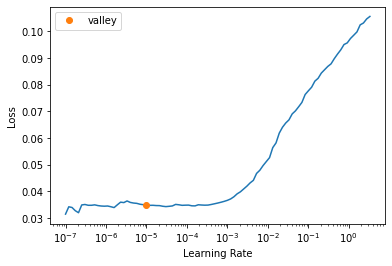

In [38]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.034449,0.041185,0.935221,0.925374,0.861112,00:07
1,0.034328,0.041179,0.935194,0.925374,0.861112,00:07
2,0.034539,0.041174,0.935187,0.925358,0.861084,00:08
3,0.034883,0.041166,0.935108,0.925396,0.861152,00:07
4,0.035032,0.041139,0.935258,0.925410,0.861175,00:08
5,0.035039,0.041109,0.935113,0.925439,0.861225,00:08
6,0.035210,0.041115,0.934921,0.925458,0.861259,00:07
7,0.034946,0.041107,0.934915,0.925451,0.861246,00:07
8,0.034851,0.041167,0.934605,0.925341,0.861056,00:08
9,0.034708,0.041154,0.934275,0.925410,0.861176,00:08


Better model found at epoch 0 with valid_loss value: 0.041185203939676285.


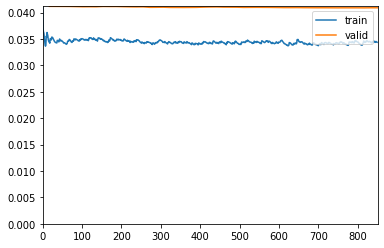

Better model found at epoch 1 with valid_loss value: 0.04117897152900696.
Better model found at epoch 2 with valid_loss value: 0.0411740243434906.
Better model found at epoch 3 with valid_loss value: 0.04116637259721756.
Better model found at epoch 4 with valid_loss value: 0.041139259934425354.
Better model found at epoch 5 with valid_loss value: 0.04110857844352722.
Better model found at epoch 7 with valid_loss value: 0.0411069393157959.
Better model found at epoch 12 with valid_loss value: 0.04109492897987366.
Better model found at epoch 13 with valid_loss value: 0.04107968881726265.
Better model found at epoch 15 with valid_loss value: 0.041001465171575546.
Better model found at epoch 18 with valid_loss value: 0.0409851148724556.
Better model found at epoch 19 with valid_loss value: 0.04098091274499893.
Better model found at epoch 20 with valid_loss value: 0.040975600481033325.
Better model found at epoch 34 with valid_loss value: 0.04097243398427963.
Better model found at epoch 35 

In [39]:
fname="HRNet_Aug_wd1_model_5_hrnet_w18_bs_32"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=5),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, slice(1e-6,1e-5), cbs=callbacksFitBeforeUnfreeze)

# Third round of training 

In [22]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="hrnet", backbone_name="hrnet_w48", 
                                 metrics=[partial(pixel_accuracy, axis=1), Dice(), JaccardCoeff()], wd=1e-3,
                                 splitter=hrnet_splitter, pretrained = True, 
                                 loss_func= DiceLoss(axis=1, smooth=1, reduction='mean', square_in_union=False)).to_fp16()
learn.freeze()

100%|██████████| 303363/303363 [00:13<00:00, 22959.00KB/s]


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Recorder

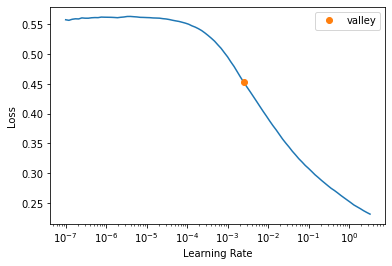

In [25]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.178711,0.451785,0.996734,0.425788,0.270477,00:12
1,0.131615,0.313386,0.993675,0.561392,0.390233,00:12
2,0.112616,0.208433,0.990057,0.675206,0.509668,00:12
3,0.100718,0.123360,0.978255,0.797939,0.663810,00:12
4,0.093102,0.098517,0.959015,0.836293,0.718646,00:12
5,0.087653,0.095855,0.962304,0.839064,0.722747,00:12
6,0.083885,0.079052,0.938565,0.864122,0.760753,00:12
7,0.081038,0.077169,0.873612,0.870015,0.769935,00:12
8,0.078597,0.081061,0.805464,0.858129,0.751511,00:12
9,0.076448,0.070738,0.881410,0.880262,0.786132,00:12


Better model found at epoch 0 with valid_loss value: 0.45178496837615967.


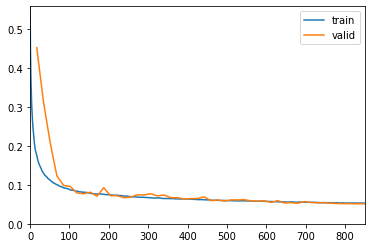

Better model found at epoch 1 with valid_loss value: 0.3133862316608429.
Better model found at epoch 2 with valid_loss value: 0.20843327045440674.
Better model found at epoch 3 with valid_loss value: 0.12336036562919617.
Better model found at epoch 4 with valid_loss value: 0.09851741045713425.
Better model found at epoch 5 with valid_loss value: 0.0958552435040474.
Better model found at epoch 6 with valid_loss value: 0.07905225455760956.
Better model found at epoch 7 with valid_loss value: 0.07716868817806244.
Better model found at epoch 9 with valid_loss value: 0.07073767483234406.
Better model found at epoch 13 with valid_loss value: 0.06701698154211044.
Better model found at epoch 21 with valid_loss value: 0.06695839017629623.
Better model found at epoch 22 with valid_loss value: 0.06389091908931732.
Better model found at epoch 26 with valid_loss value: 0.059452276676893234.
Better model found at epoch 28 with valid_loss value: 0.058438073843717575.
Better model found at epoch 33 wi

In [26]:
fname="HRNet_Aug_wd3_model_1_hrnet_w18_bs_32_Dice_loss"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=5),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, slice(1e-3,1e-1), cbs=callbacksFitBeforeUnfreeze)

In [27]:
learn.freeze()
learn.load("HRNet_Aug_wd3_model_1_hrnet_w18_bs_32_Dice_loss")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#4) [0.05135231837630272,0.9122170209884644,0.9094610262455312,0.8339555468746532]

In [28]:
lr = 3e-2
lrs = slice(lr/400, lr/4)
lr, lrs

(0.03, slice(7.5e-05, 0.0075, None))

In [29]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.052314,0.051218,0.915951,0.909824,0.834566,00:15
1,0.052336,0.052009,0.914791,0.908872,0.832965,00:15
2,0.052232,0.052233,0.905566,0.908273,0.831959,00:14
3,0.052627,0.053870,0.916500,0.907945,0.831409,00:14
4,0.052781,0.053827,0.915315,0.906515,0.829014,00:14
5,0.052854,0.052917,0.905827,0.907633,0.830886,00:15
6,0.053259,0.056100,0.935876,0.903254,0.823576,00:15
7,0.053580,0.055939,0.907119,0.902895,0.822980,00:14
8,0.053842,0.051982,0.914296,0.909186,0.833493,00:14
9,0.054504,0.055665,0.917874,0.901999,0.821492,00:15


Better model found at epoch 0 with valid_loss value: 0.05121782794594765.


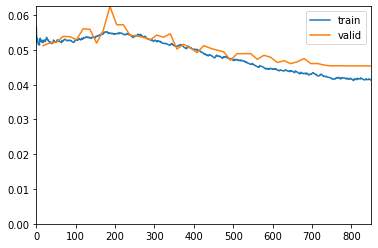

Better model found at epoch 20 with valid_loss value: 0.05026424303650856.
Better model found at epoch 23 with valid_loss value: 0.04922832176089287.
Better model found at epoch 28 with valid_loss value: 0.04703822359442711.
Better model found at epoch 35 with valid_loss value: 0.046388182789087296.
Better model found at epoch 37 with valid_loss value: 0.04604179039597511.
Better model found at epoch 42 with valid_loss value: 0.04562603682279587.
Better model found at epoch 43 with valid_loss value: 0.04540730267763138.
Better model found at epoch 46 with valid_loss value: 0.04540408030152321.
Better model found at epoch 47 with valid_loss value: 0.045393943786621094.


In [30]:
fname="HRNet_Aug_wd3_model_2_hrnet_w18_bs_32_Dice_loss"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=5),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, lrs, cbs=callbacksFitBeforeUnfreeze)

In [24]:
learn.freeze()
learn.load("HRNet_Aug_wd3_model_2_hrnet_w18_bs_32_Dice_loss")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#4) [0.045393943786621094,0.9263452887535095,0.9186455373055248,0.849532293986637]

Recorder

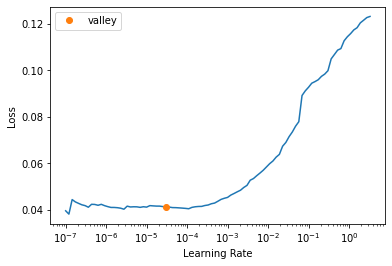

In [25]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

In [26]:
lr = slice(1e-7,3e-6)

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.041895,0.045396,0.926509,0.918623,0.849495,00:16
1,0.041254,0.045401,0.926710,0.918542,0.849356,00:16
2,0.041086,0.045402,0.926778,0.918557,0.849380,00:16
3,0.040807,0.045399,0.926817,0.918544,0.849359,00:16
4,0.041083,0.045388,0.926847,0.918533,0.849340,00:16
5,0.040929,0.045400,0.926794,0.918494,0.849273,00:16
6,0.040943,0.045405,0.926935,0.918558,0.849383,00:16
7,0.040995,0.045408,0.926900,0.918535,0.849344,00:17
8,0.040913,0.045411,0.926922,0.918572,0.849407,00:16
9,0.040846,0.045394,0.926682,0.918562,0.849389,00:16


Better model found at epoch 0 with valid_loss value: 0.04539576172828674.


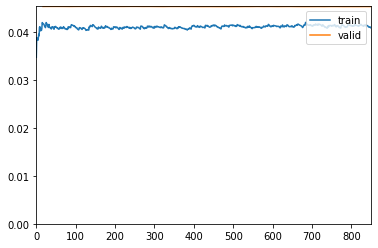

Better model found at epoch 4 with valid_loss value: 0.04538799449801445.
Better model found at epoch 17 with valid_loss value: 0.04538588225841522.
Better model found at epoch 18 with valid_loss value: 0.04538003355264664.
Better model found at epoch 23 with valid_loss value: 0.045375581830739975.
Better model found at epoch 24 with valid_loss value: 0.04537315294146538.
Better model found at epoch 26 with valid_loss value: 0.04536766558885574.
Better model found at epoch 28 with valid_loss value: 0.04536232352256775.


In [27]:
fname="HRNet_Aug_wd3_model_3_hrnet_w18_bs_32_Dice_loss"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=5),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, lr, cbs=callbacksFitBeforeUnfreeze)

In [23]:
learn.freeze()
learn.load("HRNet_Aug_wd3_model_3_hrnet_w18_bs_32_Dice_loss")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#4) [0.04536232352256775,0.9266709685325623,0.9186422478651204,0.8495266677947083]

Recorder

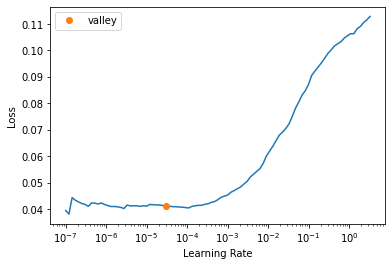

In [24]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,pixel_accuracy,dice,jaccard_coeff,time
0,0.041832,0.045362,0.926702,0.918663,0.849562,00:16
1,0.041194,0.045366,0.926851,0.918600,0.849454,00:16
2,0.041034,0.045369,0.926844,0.918625,0.849498,00:16
3,0.040755,0.045367,0.926813,0.918616,0.849482,00:15
4,0.041030,0.045357,0.926924,0.918639,0.849521,00:15
5,0.040873,0.045357,0.926875,0.918644,0.849529,00:15
6,0.040884,0.045362,0.926911,0.918598,0.849450,00:16
7,0.040933,0.045366,0.926827,0.918615,0.849481,00:16
8,0.040849,0.045378,0.926783,0.918592,0.849440,00:15
9,0.040778,0.045347,0.926563,0.918667,0.849569,00:16


Better model found at epoch 0 with valid_loss value: 0.04536205530166626.


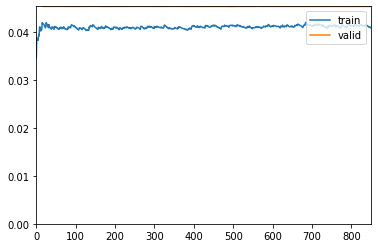

Better model found at epoch 4 with valid_loss value: 0.045357152819633484.
Better model found at epoch 5 with valid_loss value: 0.04535713791847229.
Better model found at epoch 9 with valid_loss value: 0.04534708335995674.
Better model found at epoch 24 with valid_loss value: 0.04534590616822243.
Better model found at epoch 28 with valid_loss value: 0.04533611610531807.


In [25]:
fname="HRNet_Aug_wd3_model_4_hrnet_w18_bs_32_Dice_loss"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=5),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(50, slice(1e-7,4e-6), cbs=callbacksFitBeforeUnfreeze)

In [26]:
learn.load("HRNet_Aug_wd3_model_4_hrnet_w18_bs_32_Dice_loss")
learn.validate()

(#4) [0.04533611610531807,0.9266002774238586,0.9186894577290644,0.8496074178650479]

# Mask prediction 

In [23]:
learn.load("HRNet_Aug_wd3_model_2_hrnet_w48_bs_32_Dice_loss")
learn.validate()

/opt/conda/lib/python3.7/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#4) [0.04086702689528465,0.9355419278144836,0.9258009307334333,0.8618522927650129]

In [24]:
path2 = path_images/"allRT4"
path2


Path('../dataset2/Images/allRT4')

Dont forget to run the cell below, it is really important. It formats the images that we want to predict 

In [29]:
dblock = DataBlock(blocks=(ImageBlock),get_items = get_image_files, batch_tfms=Normalize.from_stats(*imagenet_stats))
learn.dls =  dblock.dataloaders(path2, bs=7, num_workers=0)

In [30]:
import os 
import ntpath
os.mkdir('All_RT4_masks')
for file in path2.ls():
    
    filename = os.path.basename(file)
    
    if "jpg" in os.path.basename(file):
        trial = ntpath.basename(file)
        preds =learn.predict(file)
        pred_1 = preds[0][1]
        pred_arx = pred_1.numpy()
        rescaled = (755.0 / pred_arx.max() * (pred_arx - pred_arx.min())).astype(np.uint8)
        im = Image.fromarray(rescaled) 
        name_jpg = filename
        name_tif = trial[:-4] +  ".tif"
        im.save(f"All_RT4_masks/{name_tif}")
    else:
        print("are you sure the images are in jpg format? :)")

Code below for visualization withing the notebook (specific images)

../dataset2/Images/allRT4/r03c10p01*f01sk2f_Droplet_03.jpg


(48, 48)

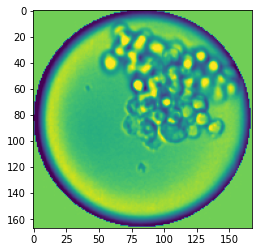

In [27]:
manual_name="allRT4"
i = 0
PATH = path_images/manual_name
files = os.listdir(f'{PATH}/')[:3]
img1 = plt.imread(f'{PATH}/{files[i]}')
img = plt.imshow(img1)
img
a,b = img1.shape

name = print(f'{PATH}/{files[i]}')
#a,b
a,b = int(round(a/3.5,0)), int(round(b/3.5, 0))
a,b
#a,b = 640, 853
#a,b =  876,1037


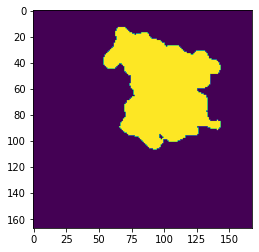

In [28]:
ls = path2.ls()
ls
i = 0
preds =learn.predict(ls[i])
pred_1 = preds[0][1]
plt.imshow(pred_1)